In [1]:
# ============================================================
# Prévision — Données mensuelles logistique
# - Chargement logistics-donnees_mensuelles_reconstituees.csv
# - Construction d'une série mensuelle (ex: PLF, Déchets, Cartons)
# - Puis: identification saisonnalité, tendance, SARIMA
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chargement des données mensuelles logistique
df = pd.read_csv("../data/logistics/logistics-donnees_mensuelles_reconstituees.csv")

# Création d'une date (1er du mois) pour l'index temporel
df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))

# Choix d'une série homogène : site + indicateur + sous-indicateur
# Exemple : Déchets - Cartons (PLF) pour anticiper les pics d'activité
SITE = "PLF"
INDICATEUR = "Déchets"
SOUS_INDICATEUR = "Cartons"

mask = (
    (df["site_code"] == SITE) &
    (df["indicateur"] == INDICATEUR) &
    (df["sous_indicateur"] == SOUS_INDICATEUR)
)
df_serie = df.loc[mask, ["date", "value"]].sort_values("date").set_index("date")

# Série mensuelle (une valeur par mois) — on somme au cas où plusieurs lignes par mois
ts = df_serie.groupby(df_serie.index)["value"].sum()
ts = ts.asfreq("MS")  # fréquence mensuelle, début de mois

# Suppression des éventuels NaN (série déjà complète en général)
ts = ts.dropna()

print(f"Série : {INDICATEUR} / {SOUS_INDICATEUR} ({SITE})")
print(f"Période : {ts.index.min()} → {ts.index.max()}, {len(ts)} mois")
ts.tail(12)

Série : Déchets / Cartons (PLF)
Période : 2011-01-01 00:00:00 → 2016-12-01 00:00:00, 72 mois


date
2016-01-01    55.80
2016-02-01    37.22
2016-03-01    26.04
2016-04-01    22.35
2016-05-01    18.55
2016-06-01    22.32
2016-07-01    48.38
2016-08-01    48.38
2016-09-01    22.32
2016-10-01    18.61
2016-11-01    14.90
2016-12-01    37.19
Freq: MS, Name: value, dtype: float64

Moyenne par mois (saisonnalité empirique) :
date
1     52.92
2     35.29
3     24.69
4     21.19
5     17.64
6     21.16
7     45.87
8     45.87
9     21.17
10    17.65
11    14.12
12    35.28
Name: value, dtype: float64


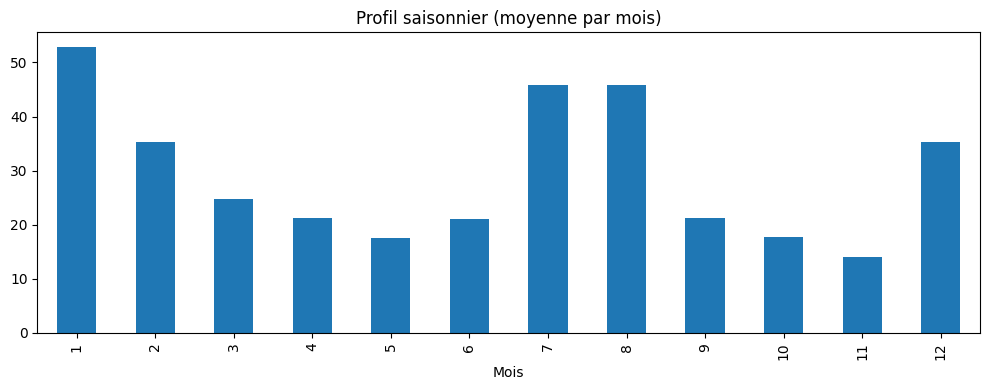

In [2]:
# Identification de la saisonnalité : moyenne par mois (1-12)
# Montre si certains mois sont systématiquement plus hauts (pics) ou plus bas
saison_mensuelle = ts.groupby(ts.index.month).mean()
print("Moyenne par mois (saisonnalité empirique) :")
print(saison_mensuelle.round(2))
saison_mensuelle.plot(kind="bar", title="Profil saisonnier (moyenne par mois)", xlabel="Mois", figsize=(10, 4))
plt.tight_layout()
plt.show()

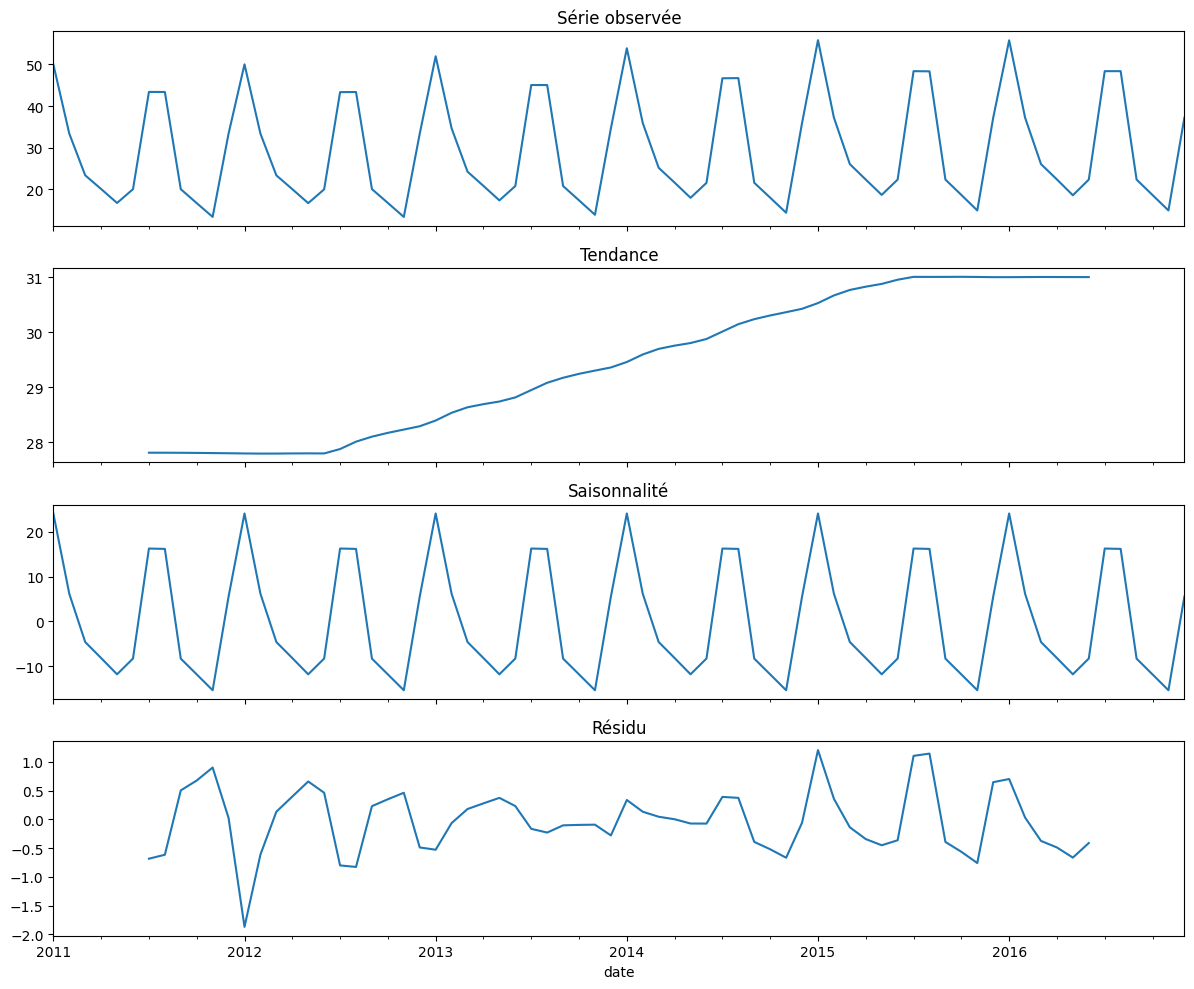

In [3]:
# Décomposition : tendance + saisonnalité + résidu
# period=12 pour données mensuelles (cycle annuel)
from statsmodels.tsa.seasonal import seasonal_decompose

# Réimport plt si exécution cellule isolée
import matplotlib.pyplot as plt

# additive si l'amplitude ne croît pas avec le niveau, sinon multiplicative
decomp = seasonal_decompose(ts, model="additive", period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomp.observed.plot(ax=axes[0], title="Série observée")
decomp.trend.plot(ax=axes[1], title="Tendance")
decomp.seasonal.plot(ax=axes[2], title="Saisonnalité")
decomp.resid.plot(ax=axes[3], title="Résidu")
plt.tight_layout()
plt.show()

In [4]:
# Modèle SARIMA : (p,d,q)(P,D,Q)s
# - s=12 pour saisonnalité annuelle (données mensuelles)
# - (p,d,q) : partie non saisonnière (ordre AR, différenciation, ordre MA)
# - (P,D,Q) : partie saisonnière
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ordres typiques pour série mensuelle avec saisonnalité annuelle
order = (1, 0, 1)           # ARIMA non saisonnier
seasonal_order = (1, 0, 1, 12)  # composante saisonnière période 12

model = SARIMAX(ts, order=order, seasonal_order=seasonal_order)
fit = model.fit(disp=False)
print("Modèle SARIMA entraîné.")
print(fit.summary().tables[1])

Modèle SARIMA entraîné.
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8143      0.094      8.665      0.000       0.630       0.998
ma.L1          0.0343      0.231      0.149      0.882      -0.418       0.487
ar.S.L12       0.9991      0.001   1972.477      0.000       0.998       1.000
ma.S.L12       0.4049      0.121      3.346      0.001       0.168       0.642
sigma2         0.1840      0.017     10.891      0.000       0.151       0.217


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


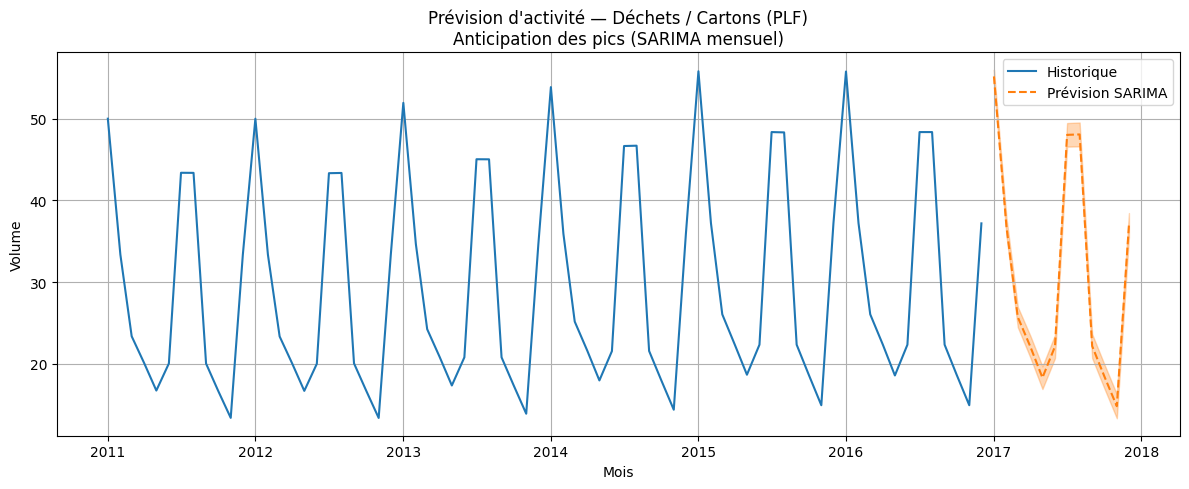


Prévision 12 prochains mois :
2017-01-01    55.20
2017-02-01    36.78
2017-03-01    25.71
2017-04-01    22.09
2017-05-01    18.27
2017-06-01    22.09
2017-07-01    48.04
2017-08-01    48.09
2017-09-01    22.15
2017-10-01    18.46
2017-11-01    14.78
2017-12-01    36.97
Freq: MS, Name: predicted_mean, dtype: float64


In [5]:
# Prévision : horizon 12 mois (1 an) après la dernière date
HORIZON = 12
forecast = fit.get_forecast(steps=HORIZON)
forecast_ts = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

# Graphique : historique + prévision + intervalle de confiance
plt.figure(figsize=(12, 5))
plt.plot(ts.index, ts.values, label="Historique", color="C0")
plt.plot(forecast_ts.index, forecast_ts.values, label="Prévision SARIMA", color="C1", linestyle="--")
plt.fill_between(forecast_ts.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=0.3, color="C1")
plt.title(f"Prévision d'activité — {INDICATEUR} / {SOUS_INDICATEUR} ({SITE})\nAnticipation des pics (SARIMA mensuel)")
plt.xlabel("Mois")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nPrévision 12 prochains mois :")
print(forecast_ts.round(2))

In [7]:
import pandas as pd
import numpy as np
import warnings

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Réduire le bruit des warnings statsmodels (séries courtes, convergence)
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", message=".*Maximum Likelihood optimization failed to converge.*")
warnings.filterwarnings("ignore", message=".*Too few observations.*", module="statsmodels")
warnings.filterwarnings("ignore", category=Warning, module="statsmodels.base.model")

# =========================
# 1. Charger les données
# =========================

df = pd.read_csv("../data/activity-service/activity-service-donnees_mensuelles_reconstituees.csv")

print("Aperçu :")
print(df.head())

# =========================
# 2. Créer une vraie date
# =========================

df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))

# =========================
# 3. Identifier les colonnes clés
# =========================

# Si sous_indicateur n'existe pas, on la crée vide
if "sous_indicateur" not in df.columns:
    df["sous_indicateur"] = "NA"

# =========================
# 4. Liste des séries à prévoir
# =========================

group_cols = ["site_code", "indicateur", "sous_indicateur"]

series_list = df[group_cols].drop_duplicates()

print("Nombre de séries à prévoir :", len(series_list))

# =========================
# 5. Fonction SARIMA Forecast
# =========================

TARGET_START = pd.Timestamp("2017-01-01")
TARGET_END   = pd.Timestamp("2017-12-01")

# Seuil au-delà duquel la prévision est considérée comme explosive (instabilité SARIMA)
MAX_FORECAST_MAGNITUDE = 1e10

def _fallback_forecast_seasonal_naive(ts, target_start, target_end):
    """Prévision de repli : pour chaque mois de 2017, moyenne des mêmes mois dans l'historique."""
    months = pd.date_range(start=target_start, end=target_end, freq="MS")
    out = {}
    for d in months:
        same_month = ts[ts.index.month == d.month]
        out[d] = same_month.mean() if len(same_month) > 0 else ts.mean()
    return pd.Series(out)


def _is_forecast_sane(pred):
    """Vérifie que la prévision ne contient pas de valeurs explosives ou non finies."""
    if pred is None or len(pred) == 0:
        return False
    if not np.isfinite(pred).all():
        return False
    if pred.abs().max() > MAX_FORECAST_MAGNITUDE:
        return False
    return True


def forecast_year_2017(ts):
    """
    ts : série mensuelle (index datetime) avec valeurs historiques
    retourne uniquement les prévisions de 2017 (Jan->Dec) + IC
    """

    # 1) Assurer une fréquence mensuelle
    ts = ts.sort_index().asfreq("MS")

    # 2) IMPORTANT : ne pas dropna si ça crée des trous énormes invisibles
    #    Ici on choisit une imputation simple pour stabiliser SARIMA
    #    (tu peux changer la méthode selon tes règles métier)
    ts = ts.interpolate("time").ffill().bfill()

    last_obs = ts.index.max()

    # 3) Si la série va déjà au-delà de 2017 (rare), on peut faire une prédiction in-sample/out-of-sample
    #    Sinon, on forecast jusqu'à 2017-12
    if last_obs >= TARGET_END:
        steps = 0
    else:
        steps = (pd.Period(TARGET_END, "M") - pd.Period(last_obs, "M")).n + 1

    model = SARIMAX(
        ts,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fit = model.fit(disp=False)

    # 4) Obtenir des prédictions jusqu'à TARGET_END
    if steps > 0:
        fc = fit.get_forecast(steps=steps)
        pred = fc.predicted_mean
        conf = fc.conf_int()
    else:
        # si la série couvre déjà 2017, on prédit directement l'intervalle demandé
        pred_res = fit.get_prediction(start=TARGET_START, end=TARGET_END)
        pred = pred_res.predicted_mean
        conf = pred_res.conf_int()

    # 5) Garder uniquement 2017
    pred_2017 = pred.loc[TARGET_START:TARGET_END]
    conf_2017 = conf.loc[TARGET_START:TARGET_END]

    # 6) Si prévision explosive (instabilité SARIMA), remplacer par fallback raisonnable
    if not _is_forecast_sane(pred_2017):
        pred_2017 = _fallback_forecast_seasonal_naive(ts, TARGET_START, TARGET_END)
        conf_2017 = pd.DataFrame({"lower": pred_2017 - pred_2017.std(), "upper": pred_2017 + pred_2017.std()})

    return pred_2017, conf_2017


def prepare_series(ts):
    """Préparation commune : fréquence mensuelle + remplissage des trous pour SARIMA."""
    ts = ts.sort_index().asfreq("MS")
    ts = ts.interpolate("time").ffill().bfill()
    return ts


def forecast_or_ratio(ts_crise_raw, ts_value_raw, pred_value, min_points=18):
    """
    Prévision value_crise : SARIMA si assez de points valides, sinon ratio historique (value_crise/value).
    Garantit toujours une sortie sans NaN.
    """
    n_valid = ts_crise_raw.notna().sum()
    if n_valid >= min_points:
        try:
            pred_crise, _ = forecast_year_2017(ts_crise_raw.copy())
            return pred_crise
        except Exception:
            pass
    # Fallback : ratio historique (scénario crise = réduction par rapport au normal)
    safe_value = ts_value_raw.replace(0, np.nan)
    ratio_series = ts_crise_raw / safe_value
    ratio = ratio_series.replace([np.inf, -np.inf], np.nan).dropna().mean()
    if pd.isna(ratio) or ratio < 0:
        ratio = 0.0
    return pred_value * ratio


# =========================
# 6. Boucle sur tous les indicateurs
# =========================

MIN_POINTS = 18
results = []

for _, row in series_list.iterrows():

    site_code = row["site_code"]
    indicateur = row["indicateur"]
    sous_ind = row["sous_indicateur"]

    mask = (
        (df["site_code"] == site_code) &
        (df["indicateur"] == indicateur) &
        (df["sous_indicateur"] == sous_ind)
    )
    sub = df.loc[mask, ["date", "value", "value_crise", "unite"]]
    unite = sub["unite"].iloc[0]

    ts_value = sub.set_index("date")["value"].sort_index()
    ts_crise = sub.set_index("date")["value_crise"].sort_index()

    if len(ts_value) < MIN_POINTS:
        print("Skip (pas assez de points):", site_code, indicateur, sous_ind)
        continue

    try:
        # Préparation identique pour les deux séries (pro)
        ts_value_prep = prepare_series(ts_value.copy())
        ts_crise_prep = prepare_series(ts_crise.copy())

        # Prévision value (toujours SARIMA)
        pred_value, _ = forecast_year_2017(ts_value_prep)
        # Prévision value_crise : SARIMA si assez de points, sinon ratio (ts_crise = brut pour le décompte)
        pred_crise = forecast_or_ratio(ts_crise, ts_value, pred_value, min_points=MIN_POINTS)

        # Bornes raisonnables à partir de l'historique (éviter toute valeur explosive résiduelle)
        v_min, v_max = ts_value.min(), ts_value.max()
        c_min, c_max = ts_crise.min(), ts_crise.max()
        margin = 0.5
        v_lo, v_hi = v_min - margin * (v_max - v_min), v_max + margin * (v_max - v_min)
        c_lo, c_hi = max(0, c_min - margin * (c_max - c_min)), c_max + margin * (c_max - c_min)

        for date in pred_value.index:
            val = pred_value.loc[date]
            cri = pred_crise.loc[date] if date in pred_crise.index else (pred_value.loc[date] * 0.0)
            if pd.isna(cri):
                cri = 0.0
            val = np.clip(float(val), v_lo, v_hi)
            cri = np.clip(float(cri), c_lo, c_hi)
            results.append({
                "year": date.year,
                "month": date.month,
                "site_code": site_code,
                "indicateur": indicateur,
                "sous_indicateur": sous_ind,
                "unite": unite,
                "value": round(val, 2),
                "value_crise": round(cri, 2),
            })

        print(site_code, indicateur, sous_ind, "last_date =", ts_value_prep.index.max())

    except Exception as e:
        print("Erreur modèle :", site_code, indicateur, sous_ind)
        print(e)

# =========================
# 7. Export final (même format que les données existantes)
# =========================

forecast_df = pd.DataFrame(results)

# Colonnes dans l'ordre pour insertion avec les autres données
out_cols = ["year", "month", "site_code", "indicateur", "sous_indicateur", "unite", "value", "value_crise"]
forecast_df = forecast_df[out_cols]

print("\nPrévisions générées :", forecast_df.shape)
print("Colonnes :", list(forecast_df.columns))

forecast_df.to_csv("../data/activity-service/forecast_2017_all_indicators.csv", index=False)

print("\n✅ Fichier exporté : forecast_2017_all_indicators.csv")

Aperçu :
   year  month site_code indicateur    sous_indicateur  unite   value  \
0  2011      1       PLF      Actes  Actes opératoires  actes  2636.0   
1  2011      2       PLF      Actes  Actes opératoires  actes  2157.0   
2  2011      3       PLF      Actes  Actes opératoires  actes  1677.0   
3  2011      4       PLF      Actes  Actes opératoires  actes  1438.0   
4  2011      5       PLF      Actes  Actes opératoires  actes  1438.0   

   value_crise  
0       1677.0  
1       2396.0  
2       3834.0  
3       3594.0  
4       2157.0  
Nombre de séries à prévoir : 222
PLF Actes Actes opératoires last_date = 2017-12-01 00:00:00
CFX Actes Actes opératoires last_date = 2017-12-01 00:00:00
PLF Actes Actes opératoires - ambulatoires last_date = 2017-12-01 00:00:00
CFX Actes Actes opératoires - ambulatoires last_date = 2017-12-01 00:00:00
PLF Activités en actes Chirurgie last_date = 2013-12-01 00:00:00
CFX Activités en actes Chirurgie last_date = 2013-12-01 00:00:00
PLF Activités en 

In [8]:
# Charger les prévisions 2017 et les données mensuelles historiques
forecast_df = pd.read_csv("../data/activity-service/forecast_2017_all_indicators.csv")
df_hist = pd.read_csv("../data/activity-service/activity-service-donnees_mensuelles_reconstituees.csv")

# Rassembler en un seul fichier (mêmes colonnes)
patients_all = pd.concat([df_hist, forecast_df], ignore_index=True)
patients_all = patients_all.sort_values(["site_code", "indicateur", "sous_indicateur", "year", "month"])

# Export
patients_all.to_csv("../data/activity-service/activity-service-all.csv", index=False)
print("Shape historique:", df_hist.shape)
print("Shape prévisions 2017:", forecast_df.shape)
print("Shape rassemblée (patients-all):", patients_all.shape)
print("\n✅ Fichier exporté : data/patients/patients-all.csv")


Shape historique: (13174, 8)
Shape prévisions 2017: (2648, 8)
Shape rassemblée (patients-all): (15822, 8)

✅ Fichier exporté : data/patients/patients-all.csv
